![ML Logo](http://spark-mooc.github.io/web-assets/images/CS190.1x_Banner_300.png)
# **Linear Regression Lab**
#### This lab covers a common supervised learning pipeline, using a subset of the [Million Song Dataset](http://labrosa.ee.columbia.edu/millionsong/) from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/YearPredictionMSD). Our goal is to train a linear regression model to predict the release year of a song given a set of audio features.
#### ** This lab will cover: **
+  ####*Part 1:* Read and parse the initial dataset
 + #### *Visualization 1:* Features
 + #### *Visualization 2:* Shifting labels
+  ####*Part 2:* Create and evaluate a baseline model
 + #### *Visualization 3:* Predicted vs. actual
+  ####*Part 3:* Train (via gradient descent) and evaluate a linear regression model
 + #### *Visualization 4:* Training error
+  ####*Part 4:* Train using MLlib and tune hyperparameters via grid search
 + #### *Visualization 5:* Best model's predictions
 + #### *Visualization 6:* Hyperparameter heat map
+  ####*Part 5:* Add interactions between features
 
#### Note that, for reference, you can look up the details of the relevant Spark methods in [Spark's Python API](https://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD) and the relevant NumPy methods in the [NumPy Reference](http://docs.scipy.org/doc/numpy/reference/index.html)

In [1]:
labVersion = 'cs190_week3_v_1_3'

### ** Part 1: Read and parse the initial dataset **

#### ** (1a) Load and check the data **
#### The raw data is currently stored in text file.  We will start by storing this raw data in as an RDD, with each element of the RDD representing a data point as a comma-delimited string. Each string starts with the label (a year) followed by numerical audio features. Use the [count method](https://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD.count) to check how many data points we have.  Then use the [take method](https://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD.take) to create and print out a list of the first 5 data points in their initial string format.

In [1]:
# load testing library
from test_helper import Test
import os.path
baseDir = os.path.join('data')
inputPath = os.path.join('cs190', 'millionsong.txt')
fileName = os.path.join(baseDir, inputPath)

numPartitions = 2
rawData = sc.textFile(fileName, numPartitions)

In [3]:
# TODO: Replace <FILL IN> with appropriate code
numPoints = rawData.count()
print numPoints
samplePoints = rawData.take(5)
print samplePoints

6724
[u'2001.0,0.884123733793,0.610454259079,0.600498416968,0.474669212493,0.247232680947,0.357306088914,0.344136412234,0.339641227335,0.600858840135,0.425704689024,0.60491501652,0.419193351817', u'2001.0,0.854411946129,0.604124786151,0.593634078776,0.495885413963,0.266307830936,0.261472105188,0.506387076327,0.464453565511,0.665798573683,0.542968988766,0.58044428577,0.445219373624', u'2001.0,0.908982970575,0.632063159227,0.557428975183,0.498263761394,0.276396052336,0.312809861625,0.448530069406,0.448674249968,0.649791323916,0.489868662682,0.591908113534,0.4500023818', u'2001.0,0.842525219898,0.561826888508,0.508715259692,0.443531142139,0.296733836002,0.250213568176,0.488540873206,0.360508747659,0.575435243185,0.361005878554,0.678378718617,0.409036786173', u'2001.0,0.909303285534,0.653607720915,0.585580794716,0.473250503005,0.251417011835,0.326976795524,0.40432273022,0.371154511756,0.629401917965,0.482243251755,0.566901413923,0.463373691946']


In [4]:
# TEST Load and check the data (1a)
Test.assertEquals(numPoints, 6724, 'incorrect value for numPoints')
Test.assertEquals(len(samplePoints), 5, 'incorrect length for samplePoints')

1 test passed.
1 test passed.


#### ** (1b) Using `LabeledPoint` **
#### In MLlib, labeled training instances are stored using the [LabeledPoint](https://spark.apache.org/docs/latest/api/python/pyspark.mllib.html#pyspark.mllib.regression.LabeledPoint) object.  Write the parsePoint function that takes as input a raw data point, parses it using Python's [unicode.split](https://docs.python.org/2/library/string.html#string.split) method, and returns a `LabeledPoint`.  Use this function to parse samplePoints (from the previous question).  Then print out the features and label for the first training point, using the `LabeledPoint.features` and `LabeledPoint.label` attributes. Finally, calculate the number features for this dataset.
#### Note that `split()` can be called directly on a `unicode` or `str` object.  For example, `u'split,me'.split(',')` returns `[u'split', u'me']`.

In [5]:
from pyspark.mllib.regression import LabeledPoint
import numpy as np

# Here is a sample raw data point:
# '2001.0,0.884,0.610,0.600,0.474,0.247,0.357,0.344,0.33,0.600,0.425,0.60,0.419'
# In this raw data point, 2001.0 is the label, and the remaining values are features

In [22]:
# TODO: Replace <FILL IN> with appropriate code
def parsePoint(line):
    """Converts a comma separated unicode string into a `LabeledPoint`.

    Args:
        line (unicode): Comma separated unicode string where the first element is the label and the
            remaining elements are features.

    Returns:
        LabeledPoint: The line is converted into a `LabeledPoint`, which consists of a label and
            features.
    """
    tokens = line.split(',')
    label, features = tokens[0], tokens[1:]
    return LabeledPoint(label, features)

parsedSamplePoints = [parsePoint(points) for points in samplePoints]

firstPointFeatures = parsedSamplePoints[0].features
firstPointLabel = parsedSamplePoints[0].label
print firstPointFeatures, firstPointLabel

d = len(firstPointFeatures)
print d

[0.884123733793,0.610454259079,0.600498416968,0.474669212493,0.247232680947,0.357306088914,0.344136412234,0.339641227335,0.600858840135,0.425704689024,0.60491501652,0.419193351817] 2001.0
12


In [21]:
# TEST Using LabeledPoint (1b)
Test.assertTrue(isinstance(firstPointLabel, float), 'label must be a float')
expectedX0 = [0.8841,0.6105,0.6005,0.4747,0.2472,0.3573,0.3441,0.3396,0.6009,0.4257,0.6049,0.4192]
Test.assertTrue(np.allclose(expectedX0, firstPointFeatures, 1e-4, 1e-4),
                'incorrect features for firstPointFeatures')
Test.assertTrue(np.allclose(2001.0, firstPointLabel), 'incorrect label for firstPointLabel')
Test.assertTrue(d == 12, 'incorrect number of features')

1 test passed.
1 test passed.
1 test passed.
1 test passed.


#### **Visualization 1: Features**
#### First we will load and setup the visualization library.  Then we will look at the raw features for 50 data points by generating a heatmap that visualizes each feature on a grey-scale and shows the variation of each feature across the 50 sample data points.  The features are all between 0 and 1, with values closer to 1 represented via darker shades of grey.

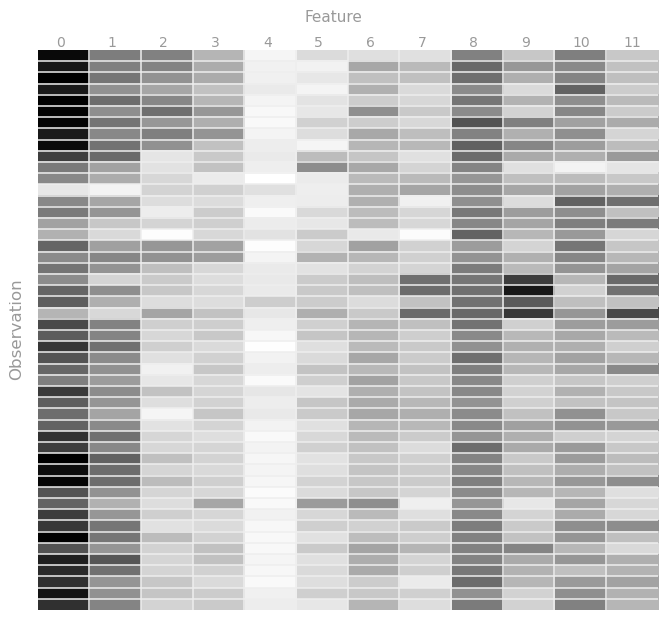

In [26]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

sampleMorePoints = rawData.take(50)
# You can uncomment the line below to see randomly selected features.  These will be randomly
# selected each time you run the cell.  Note that you should run this cell with the line commented
# out when answering the lab quiz questions.
# sampleMorePoints = rawData.takeSample(False, 50)

parsedSampleMorePoints = map(parsePoint, sampleMorePoints)
dataValues = map(lambda lp: lp.features.toArray(), parsedSampleMorePoints)

def preparePlot(xticks, yticks, figsize=(10.5, 6), hideLabels=False, gridColor='#999999',
                gridWidth=1.0):
    """Template for generating the plot layout."""
    plt.close()
    fig, ax = plt.subplots(figsize=figsize, facecolor='white', edgecolor='white')
    ax.axes.tick_params(labelcolor='#999999', labelsize='10')
    for axis, ticks in [(ax.get_xaxis(), xticks), (ax.get_yaxis(), yticks)]:
        axis.set_ticks_position('none')
        axis.set_ticks(ticks)
        axis.label.set_color('#999999')
        if hideLabels: axis.set_ticklabels([])
    plt.grid(color=gridColor, linewidth=gridWidth, linestyle='-')
    map(lambda position: ax.spines[position].set_visible(False), ['bottom', 'top', 'left', 'right'])
    return fig, ax

# generate layout and plot
fig, ax = preparePlot(np.arange(.5, 11, 1), np.arange(.5, 49, 1), figsize=(8,7), hideLabels=True,
                      gridColor='#eeeeee', gridWidth=1.1)
image = plt.imshow(dataValues,interpolation='nearest', aspect='auto', cmap=cm.Greys)
for x, y, s in zip(np.arange(-.125, 12, 1), np.repeat(-.75, 12), [str(x) for x in range(12)]):
    plt.text(x, y, s, color='#999999', size='10')
plt.text(4.7, -3, 'Feature', color='#999999', size='11'), ax.set_ylabel('Observation')
pass

#### **(1c) Find the range **
#### Now let's examine the labels to find the range of song years.  To do this, first parse each element of the `rawData` RDD, and then find the smallest and largest labels.

In [28]:
# TODO: Replace <FILL IN> with appropriate code
parsedDataInit = rawData.map(parsePoint)
onlyLabels = parsedDataInit.map(lambda point: point.label).collect()
minYear = min(onlyLabels)
maxYear = max(onlyLabels)
print maxYear, minYear

2011.0 1922.0


In [29]:
# TEST Find the range (1c)
Test.assertEquals(len(parsedDataInit.take(1)[0].features), 12,
                  'unexpected number of features in sample point')
sumFeatTwo = parsedDataInit.map(lambda lp: lp.features[2]).sum()
Test.assertTrue(np.allclose(sumFeatTwo, 3158.96224351), 'parsedDataInit has unexpected values')
yearRange = maxYear - minYear
Test.assertTrue(yearRange == 89, 'incorrect range for minYear to maxYear')

1 test passed.
1 test passed.
1 test passed.


#### **(1d) Shift labels **
#### As we just saw, the labels are years in the 1900s and 2000s.  In learning problems, it is often natural to shift labels such that they start from zero.  Starting with `parsedDataInit`, create a new RDD consisting of `LabeledPoint` objects in which the labels are shifted such that smallest label equals zero.

In [30]:
# TODO: Replace <FILL IN> with appropriate code
parsedData = parsedDataInit.map(lambda lp: LabeledPoint(lp.label - minYear, lp.features))

# Should be a LabeledPoint
print type(parsedData.take(1)[0])
# View the first point
print '\n{0}'.format(parsedData.take(1))

<class 'pyspark.mllib.regression.LabeledPoint'>

[LabeledPoint(79.0, [0.884123733793,0.610454259079,0.600498416968,0.474669212493,0.247232680947,0.357306088914,0.344136412234,0.339641227335,0.600858840135,0.425704689024,0.60491501652,0.419193351817])]


In [31]:
# TEST Shift labels (1d)
oldSampleFeatures = parsedDataInit.take(1)[0].features
newSampleFeatures = parsedData.take(1)[0].features
Test.assertTrue(np.allclose(oldSampleFeatures, newSampleFeatures),
                'new features do not match old features')
sumFeatTwo = parsedData.map(lambda lp: lp.features[2]).sum()
Test.assertTrue(np.allclose(sumFeatTwo, 3158.96224351), 'parsedData has unexpected values')
minYearNew = parsedData.map(lambda lp: lp.label).min()
maxYearNew = parsedData.map(lambda lp: lp.label).max()
Test.assertTrue(minYearNew == 0, 'incorrect min year in shifted data')
Test.assertTrue(maxYearNew == 89, 'incorrect max year in shifted data')

1 test passed.
1 test passed.
1 test passed.
1 test passed.


#### ** Visualization 2: Shifting labels **
#### We will look at the labels before and after shifting them.  Both scatter plots below visualize tuples storing i) a label value and ii) the number of training points with this label.  The first scatter plot uses the initial labels, while the second one uses the shifted labels.  Note that the two plots look the same except for the labels on the x-axis.

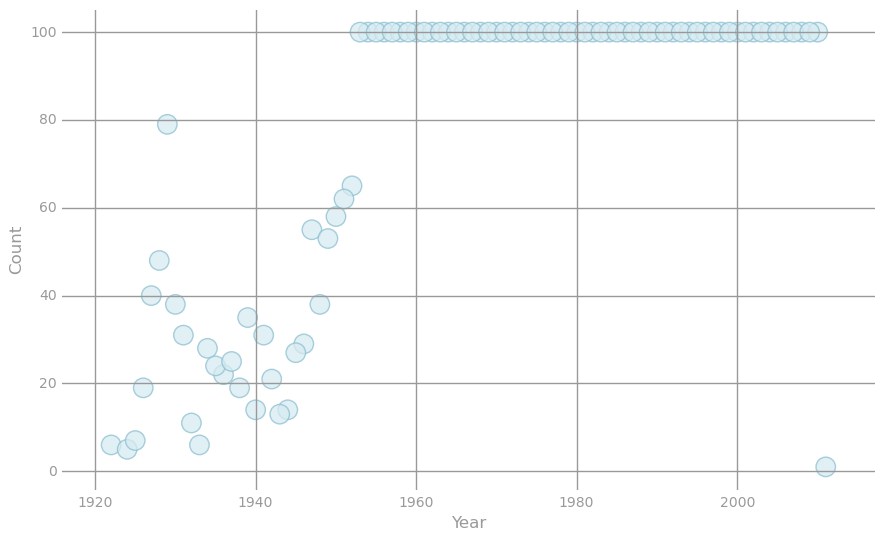

In [32]:
# get data for plot
oldData = (parsedDataInit
           .map(lambda lp: (lp.label, 1))
           .reduceByKey(lambda x, y: x + y)
           .collect())
x, y = zip(*oldData)

# generate layout and plot data
fig, ax = preparePlot(np.arange(1920, 2050, 20), np.arange(0, 150, 20))
plt.scatter(x, y, s=14**2, c='#d6ebf2', edgecolors='#8cbfd0', alpha=0.75)
ax.set_xlabel('Year'), ax.set_ylabel('Count')
pass

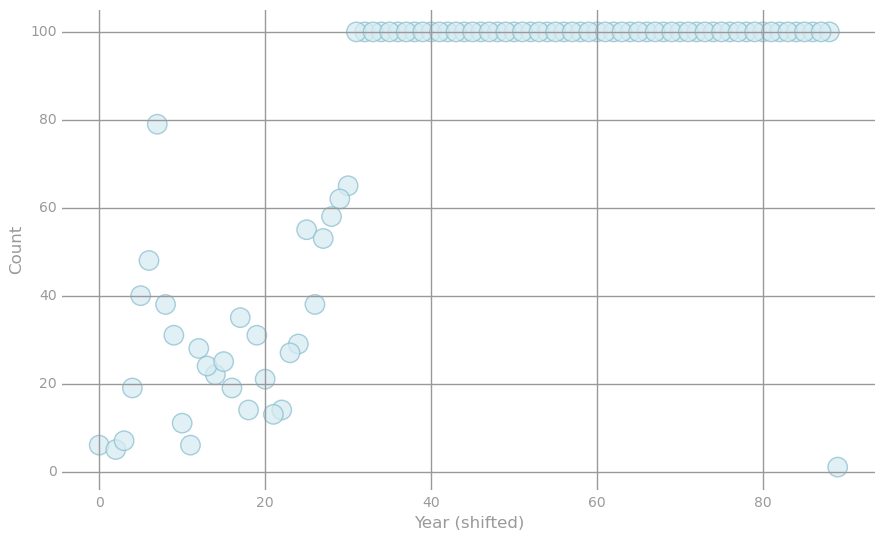

In [33]:
# get data for plot
newData = (parsedData
           .map(lambda lp: (lp.label, 1))
           .reduceByKey(lambda x, y: x + y)
           .collect())
x, y = zip(*newData)

# generate layout and plot data
fig, ax = preparePlot(np.arange(0, 120, 20), np.arange(0, 120, 20))
plt.scatter(x, y, s=14**2, c='#d6ebf2', edgecolors='#8cbfd0', alpha=0.75)
ax.set_xlabel('Year (shifted)'), ax.set_ylabel('Count')
pass

#### ** (1e) Training, validation, and test sets **
#### We're almost done parsing our dataset, and our final task involves split it into training, validation and test sets. Use the [randomSplit method](https://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD.randomSplit) with the specified weights and seed to create RDDs storing each of these datasets. Next, cache each of these RDDs, as we will be accessing them multiple times in the remainder of this lab. Finally, compute the size of each dataset and verify that the sum of their sizes equals the value computed in Part (1a).

In [34]:
# TODO: Replace <FILL IN> with appropriate code
weights = [.8, .1, .1]
seed = 42
parsedTrainData, parsedValData, parsedTestData = parsedData.randomSplit(weights, seed)
parsedTrainData.cache()
parsedValData.cache()
parsedTestData.cache()
nTrain = parsedTrainData.count()
nVal = parsedValData.count()
nTest = parsedTestData.count()

print nTrain, nVal, nTest, nTrain + nVal + nTest
print parsedData.count()

5371 682 671 6724
6724


In [35]:
# TEST Training, validation, and test sets (1e)
Test.assertEquals(parsedTrainData.getNumPartitions(), numPartitions,
                  'parsedTrainData has wrong number of partitions')
Test.assertEquals(parsedValData.getNumPartitions(), numPartitions,
                  'parsedValData has wrong number of partitions')
Test.assertEquals(parsedTestData.getNumPartitions(), numPartitions,
                  'parsedTestData has wrong number of partitions')
Test.assertEquals(len(parsedTrainData.take(1)[0].features), 12,
                  'parsedTrainData has wrong number of features')
sumFeatTwo = (parsedTrainData
              .map(lambda lp: lp.features[2])
              .sum())
sumFeatThree = (parsedValData
                .map(lambda lp: lp.features[3])
                .reduce(lambda x, y: x + y))
sumFeatFour = (parsedTestData
               .map(lambda lp: lp.features[4])
               .reduce(lambda x, y: x + y))
Test.assertTrue(np.allclose([sumFeatTwo, sumFeatThree, sumFeatFour],
                            2526.87757656, 297.340394298, 184.235876654),
                'parsed Train, Val, Test data has unexpected values')
Test.assertTrue(nTrain + nVal + nTest == 6724, 'unexpected Train, Val, Test data set size')
Test.assertEquals(nTrain, 5371, 'unexpected value for nTrain')
Test.assertEquals(nVal, 682, 'unexpected value for nVal')
Test.assertEquals(nTest, 671, 'unexpected value for nTest')

1 test passed.
1 test passed.
1 test passed.
1 test passed.
1 test passed.
1 test passed.
1 test passed.
1 test passed.
1 test passed.


### ** Part 2: Create and evaluate a baseline model **

#### **(2a) Average label **
#### A very simple yet natural baseline model is one where we always make the same prediction independent of the given data point, using the average label in the training set as the constant prediction value.  Compute this value, which is the average (shifted) song year for the training set.  Use an appropriate method in the [RDD API](https://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD).

In [ ]:
# TODO: Replace <FILL IN> with appropriate code
averageTrainYear = (parsedTrainData
                    <FILL IN>)
print averageTrainYear

In [ ]:
# TEST Average label (2a)
Test.assertTrue(np.allclose(averageTrainYear, 53.9316700801),
                'incorrect value for averageTrainYear')

#### **(2b) Root mean squared error **
#### We naturally would like to see how well this naive baseline performs.  We will use root mean squared error ([RMSE](http://en.wikipedia.org/wiki/Root-mean-square_deviation)) for evaluation purposes.  Implement a function to compute RMSE given an RDD of (label, prediction) tuples, and test out this function on an example.

In [ ]:
# TODO: Replace <FILL IN> with appropriate code
def squaredError(label, prediction):
    """Calculates the the squared error for a single prediction.

    Args:
        label (float): The correct value for this observation.
        prediction (float): The predicted value for this observation.

    Returns:
        float: The difference between the `label` and `prediction` squared.
    """
    <FILL IN>

def calcRMSE(labelsAndPreds):
    """Calculates the root mean squared error for an `RDD` of (label, prediction) tuples.

    Args:
        labelsAndPred (RDD of (float, float)): An `RDD` consisting of (label, prediction) tuples.

    Returns:
        float: The square root of the mean of the squared errors.
    """
    <FILL IN>

labelsAndPreds = sc.parallelize([(3., 1.), (1., 2.), (2., 2.)])
# RMSE = sqrt[((3-1)^2 + (1-2)^2 + (2-2)^2) / 3] = 1.291
exampleRMSE = calcRMSE(labelsAndPreds)
print exampleRMSE

In [ ]:
# TEST Root mean squared error (2b)
Test.assertTrue(np.allclose(squaredError(3, 1), 4.), 'incorrect definition of squaredError')
Test.assertTrue(np.allclose(exampleRMSE, 1.29099444874), 'incorrect value for exampleRMSE')

#### **(2c) Training, validation and test RMSE **
#### Now let's calculate the training, validation and test RMSE of our baseline model. To do this, first create RDDs of (label, prediction) tuples for each dataset, and then call calcRMSE. Note that each RMSE can be interpreted as the average prediction error for the given dataset (in terms of number of years).

In [ ]:
# TODO: Replace <FILL IN> with appropriate code
labelsAndPredsTrain = parsedTrainData.<FILL IN>
rmseTrainBase = <FILL IN>

labelsAndPredsVal = parsedValData.<FILL IN>
rmseValBase = <FILL IN>

labelsAndPredsTest = parsedTestData.<FILL IN>
rmseTestBase = <FILL IN>

print 'Baseline Train RMSE = {0:.3f}'.format(rmseTrainBase)
print 'Baseline Validation RMSE = {0:.3f}'.format(rmseValBase)
print 'Baseline Test RMSE = {0:.3f}'.format(rmseTestBase)

In [ ]:
# TEST Training, validation and test RMSE (2c)
Test.assertTrue(np.allclose([rmseTrainBase, rmseValBase, rmseTestBase],
                            [21.305869, 21.586452, 22.136957]), 'incorrect RMSE value')

#### ** Visualization 3: Predicted vs. actual **
#### We will visualize predictions on the validation dataset. The scatter plots below visualize tuples storing i) the predicted value and ii) true label.  The first scatter plot represents the ideal situation where the predicted value exactly equals the true label, while the second plot uses the baseline predictor (i.e., `averageTrainYear`) for all predicted values.  Further note that the points in the scatter plots are color-coded, ranging from light yellow when the true and predicted values are equal to bright red when they drastically differ.

In [ ]:
from matplotlib.colors import ListedColormap, Normalize
from matplotlib.cm import get_cmap
cmap = get_cmap('YlOrRd')
norm = Normalize()

actual = np.asarray(parsedValData
                    .map(lambda lp: lp.label)
                    .collect())
error = np.asarray(parsedValData
                   .map(lambda lp: (lp.label, lp.label))
                   .map(lambda (l, p): squaredError(l, p))
                   .collect())
clrs = cmap(np.asarray(norm(error)))[:,0:3]

fig, ax = preparePlot(np.arange(0, 100, 20), np.arange(0, 100, 20))
plt.scatter(actual, actual, s=14**2, c=clrs, edgecolors='#888888', alpha=0.75, linewidths=0.5)
ax.set_xlabel('Predicted'), ax.set_ylabel('Actual')
pass

In [ ]:
predictions = np.asarray(parsedValData
                         .map(lambda lp: averageTrainYear)
                         .collect())
error = np.asarray(parsedValData
                   .map(lambda lp: (lp.label, averageTrainYear))
                   .map(lambda (l, p): squaredError(l, p))
                   .collect())
norm = Normalize()
clrs = cmap(np.asarray(norm(error)))[:,0:3]

fig, ax = preparePlot(np.arange(53.0, 55.0, 0.5), np.arange(0, 100, 20))
ax.set_xlim(53, 55)
plt.scatter(predictions, actual, s=14**2, c=clrs, edgecolors='#888888', alpha=0.75, linewidths=0.3)
ax.set_xlabel('Predicted'), ax.set_ylabel('Actual')

### ** Part 3: Train (via gradient descent) and evaluate a linear regression model **

#### ** (3a) Gradient summand **
#### Now let's see if we can do better via linear regression, training a model via gradient descent (we'll omit the intercept for now). Recall that the gradient descent update for linear regression is: $$ \scriptsize \mathbf{w}_{i+1} = \mathbf{w}_i - \alpha_i \sum_j (\mathbf{w}_i^\top\mathbf{x}_j  - y_j) \mathbf{x}_j \,.$$ where $ \scriptsize i $ is the iteration number of the gradient descent algorithm, and $ \scriptsize j $ identifies the observation.
#### First, implement a function that computes the summand for this update, i.e., the summand equals $ \scriptsize (\mathbf{w}^\top \mathbf{x} - y) \mathbf{x} \, ,$ and test out this function on two examples.  Use the `DenseVector` [dot](http://spark.apache.org/docs/latest/api/python/pyspark.mllib.html#pyspark.mllib.linalg.DenseVector.dot) method.

In [ ]:
from pyspark.mllib.linalg import DenseVector

In [ ]:
# TODO: Replace <FILL IN> with appropriate code
def gradientSummand(weights, lp):
    """Calculates the gradient summand for a given weight and `LabeledPoint`.

    Note:
        `DenseVector` behaves similarly to a `numpy.ndarray` and they can be used interchangably
        within this function.  For example, they both implement the `dot` method.

    Args:
        weights (DenseVector): An array of model weights (betas).
        lp (LabeledPoint): The `LabeledPoint` for a single observation.

    Returns:
        DenseVector: An array of values the same length as `weights`.  The gradient summand.
    """
    <FILL IN>

exampleW = DenseVector([1, 1, 1])
exampleLP = LabeledPoint(2.0, [3, 1, 4])
# gradientSummand = (dot([1 1 1], [3 1 4]) - 2) * [3 1 4] = (8 - 2) * [3 1 4] = [18 6 24]
summandOne = gradientSummand(exampleW, exampleLP)
print summandOne

exampleW = DenseVector([.24, 1.2, -1.4])
exampleLP = LabeledPoint(3.0, [-1.4, 4.2, 2.1])
summandTwo = gradientSummand(exampleW, exampleLP)
print summandTwo

In [ ]:
# TEST Gradient summand (3a)
Test.assertTrue(np.allclose(summandOne, [18., 6., 24.]), 'incorrect value for summandOne')
Test.assertTrue(np.allclose(summandTwo, [1.7304,-5.1912,-2.5956]), 'incorrect value for summandTwo')

#### ** (3b) Use weights to make predictions **
#### Next, implement a `getLabeledPredictions` function that takes in weights and an observation's `LabeledPoint` and returns a (label, prediction) tuple.  Note that we can predict by computing the dot product between weights and an observation's features.

In [ ]:
# TODO: Replace <FILL IN> with appropriate code
def getLabeledPrediction(weights, observation):
    """Calculates predictions and returns a (label, prediction) tuple.

    Note:
        The labels should remain unchanged as we'll use this information to calculate prediction
        error later.

    Args:
        weights (np.ndarray): An array with one weight for each features in `trainData`.
        observation (LabeledPoint): A `LabeledPoint` that contain the correct label and the
            features for the data point.

    Returns:
        tuple: A (label, prediction) tuple.
    """
    return <FILL IN>

weights = np.array([1.0, 1.5])
predictionExample = sc.parallelize([LabeledPoint(2, np.array([1.0, .5])),
                                    LabeledPoint(1.5, np.array([.5, .5]))])
labelsAndPredsExample = predictionExample.map(lambda lp: getLabeledPrediction(weights, lp))
print labelsAndPredsExample.collect()

In [ ]:
# TEST Use weights to make predictions (3b)
Test.assertEquals(labelsAndPredsExample.collect(), [(2.0, 1.75), (1.5, 1.25)],
                  'incorrect definition for getLabeledPredictions')

#### ** (3c) Gradient descent **
#### Next, implement a gradient descent function for linear regression and test out this function on an example.

In [ ]:
# TODO: Replace <FILL IN> with appropriate code
def linregGradientDescent(trainData, numIters):
    """Calculates the weights and error for a linear regression model trained with gradient descent.

    Note:
        `DenseVector` behaves similarly to a `numpy.ndarray` and they can be used interchangably
        within this function.  For example, they both implement the `dot` method.

    Args:
        trainData (RDD of LabeledPoint): The labeled data for use in training the model.
        numIters (int): The number of iterations of gradient descent to perform.

    Returns:
        (np.ndarray, np.ndarray): A tuple of (weights, training errors).  Weights will be the
            final weights (one weight per feature) for the model, and training errors will contain
            an error (RMSE) for each iteration of the algorithm.
    """
    # The length of the training data
    n = trainData.count()
    # The number of features in the training data
    d = len(trainData.take(1)[0].features)
    w = np.zeros(d)
    alpha = 1.0
    # We will compute and store the training error after each iteration
    errorTrain = np.zeros(numIters)
    for i in range(numIters):
        # Use getLabeledPrediction from (3b) with trainData to obtain an RDD of (label, prediction)
        # tuples.  Note that the weights all equal 0 for the first iteration, so the predictions will
        # have large errors to start.
        labelsAndPredsTrain = trainData.<FILL IN>
        errorTrain[i] = calcRMSE(labelsAndPredsTrain)

        # Calculate the `gradient`.  Make use of the `gradientSummand` function you wrote in (3a).
        # Note that `gradient` sould be a `DenseVector` of length `d`.
        gradient = <FILL IN>

        # Update the weights
        alpha_i = alpha / (n * np.sqrt(i+1))
        w -= <FILL IN>
    return w, errorTrain

# create a toy dataset with n = 10, d = 3, and then run 5 iterations of gradient descent
# note: the resulting model will not be useful; the goal here is to verify that
# linregGradientDescent is working properly
exampleN = 10
exampleD = 3
exampleData = (sc
               .parallelize(parsedTrainData.take(exampleN))
               .map(lambda lp: LabeledPoint(lp.label, lp.features[0:exampleD])))
print exampleData.take(2)
exampleNumIters = 5
exampleWeights, exampleErrorTrain = linregGradientDescent(exampleData, exampleNumIters)
print exampleWeights

In [ ]:
# TEST Gradient descent (3c)
expectedOutput = [48.88110449,  36.01144093, 30.25350092]
Test.assertTrue(np.allclose(exampleWeights, expectedOutput), 'value of exampleWeights is incorrect')
expectedError = [79.72013547, 30.27835699,  9.27842641,  9.20967856,  9.19446483]
Test.assertTrue(np.allclose(exampleErrorTrain, expectedError),
                'value of exampleErrorTrain is incorrect')

#### ** (3d) Train the model **
#### Now let's train a linear regression model on all of our training data and evaluate its accuracy on the validation set.  Note that the test set will not be used here.  If we evaluated the model on the test set, we would bias our final results.
#### We've already done much of the required work: we computed the number of features in Part (1b); we created the training and validation datasets and computed their sizes in Part (1e); and, we wrote a function to compute RMSE in Part (2b).

In [ ]:
# TODO: Replace <FILL IN> with appropriate code
numIters = 50
weightsLR0, errorTrainLR0 = linregGradientDescent(<FILL IN>)

labelsAndPreds = parsedValData.<FILL IN>
rmseValLR0 = calcRMSE(labelsAndPreds)

print 'Validation RMSE:\n\tBaseline = {0:.3f}\n\tLR0 = {1:.3f}'.format(rmseValBase,
                                                                       rmseValLR0)

In [ ]:
# TEST Train the model (3d)
expectedOutput = [22.64535883, 20.064699, -0.05341901, 8.2931319, 5.79155768, -4.51008084,
                  15.23075467, 3.8465554, 9.91992022, 5.97465933, 11.36849033, 3.86452361]
Test.assertTrue(np.allclose(weightsLR0, expectedOutput), 'incorrect value for weightsLR0')

#### ** Visualization 4: Training error **
#### We will look at the log of the training error as a function of iteration. The first scatter plot visualizes the logarithm of the training error for all 50 iterations.  The second plot shows the training error itself, focusing on the final 44 iterations.

In [ ]:
norm = Normalize()
clrs = cmap(np.asarray(norm(np.log(errorTrainLR0))))[:,0:3]

fig, ax = preparePlot(np.arange(0, 60, 10), np.arange(2, 6, 1))
ax.set_ylim(2, 6)
plt.scatter(range(0, numIters), np.log(errorTrainLR0), s=14**2, c=clrs, edgecolors='#888888', alpha=0.75)
ax.set_xlabel('Iteration'), ax.set_ylabel(r'$\log_e(errorTrainLR0)$')
pass

In [ ]:
norm = Normalize()
clrs = cmap(np.asarray(norm(errorTrainLR0[6:])))[:,0:3]

fig, ax = preparePlot(np.arange(0, 60, 10), np.arange(17, 22, 1))
ax.set_ylim(17.8, 21.2)
plt.scatter(range(0, numIters-6), errorTrainLR0[6:], s=14**2, c=clrs, edgecolors='#888888', alpha=0.75)
ax.set_xticklabels(map(str, range(6, 66, 10)))
ax.set_xlabel('Iteration'), ax.set_ylabel(r'Training Error')
pass

### ** Part 4: Train using MLlib and perform grid search **

#### **(4a) `LinearRegressionWithSGD` **
#### We're already doing better than the baseline model, but let's see if we can do better by adding an intercept, using regularization, and (based on the previous visualization) training for more iterations.  MLlib's [LinearRegressionWithSGD](https://spark.apache.org/docs/latest/api/python/pyspark.mllib.html#pyspark.mllib.regression.LinearRegressionWithSGD) essentially implements the same algorithm that we implemented in Part (3b), albeit more efficiently and with various additional functionality, such as stochastic gradient approximation, including an intercept in the model and also allowing L1 or L2 regularization.  First use LinearRegressionWithSGD to train a model with L2 regularization and with an intercept.  This method returns a [LinearRegressionModel](https://spark.apache.org/docs/latest/api/python/pyspark.mllib.html#pyspark.mllib.regression.LinearRegressionModel).  Next, use the model's [weights](http://spark.apache.org/docs/latest/api/python/pyspark.mllib.html#pyspark.mllib.regression.LinearRegressionModel.weights) and [intercept](http://spark.apache.org/docs/latest/api/python/pyspark.mllib.html#pyspark.mllib.regression.LinearRegressionModel.intercept) attributes to print out the model's parameters.

In [ ]:
from pyspark.mllib.regression import LinearRegressionWithSGD
# Values to use when training the linear regression model
numIters = 500  # iterations
alpha = 1.0  # step
miniBatchFrac = 1.0  # miniBatchFraction
reg = 1e-1  # regParam
regType = 'l2'  # regType
useIntercept = True  # intercept

In [ ]:
# TODO: Replace <FILL IN> with appropriate code
firstModel = LinearRegressionWithSGD.<FILL IN>

# weightsLR1 stores the model weights; interceptLR1 stores the model intercept
weightsLR1 = <FILL IN>
interceptLR1 = <FILL IN>
print weightsLR1, interceptLR1

In [ ]:
# TEST LinearRegressionWithSGD (4a)
expectedIntercept = 13.3335907631
expectedWeights = [16.682292427, 14.7439059559, -0.0935105608897, 6.22080088829, 4.01454261926, -3.30214858535,
                   11.0403027232, 2.67190962854, 7.18925791279, 4.46093254586, 8.14950409475, 2.75135810882]
Test.assertTrue(np.allclose(interceptLR1, expectedIntercept), 'incorrect value for interceptLR1')
Test.assertTrue(np.allclose(weightsLR1, expectedWeights), 'incorrect value for weightsLR1')

#### **(4b) Predict**
#### Now use the [LinearRegressionModel.predict()](http://spark.apache.org/docs/latest/api/python/pyspark.mllib.html#pyspark.mllib.regression.LinearRegressionModel.predict) method to make a prediction on a sample point.  Pass the `features` from a `LabeledPoint` into the `predict()` method.

In [ ]:
# TODO: Replace <FILL IN> with appropriate code
samplePoint = parsedTrainData.take(1)[0]
samplePrediction = <FILL IN>
print samplePrediction

In [ ]:
# TEST Predict (4b)
Test.assertTrue(np.allclose(samplePrediction, 56.8013380112),
                'incorrect value for samplePrediction')

#### ** (4c) Evaluate RMSE **
#### Next evaluate the accuracy of this model on the validation set.  Use the `predict()` method to create a `labelsAndPreds` RDD, and then use the `calcRMSE()` function from Part (2b).

In [ ]:
# TODO: Replace <FILL IN> with appropriate code
labelsAndPreds = <FILL IN>
rmseValLR1 = <FILL IN>

print ('Validation RMSE:\n\tBaseline = {0:.3f}\n\tLR0 = {1:.3f}' +
       '\n\tLR1 = {2:.3f}').format(rmseValBase, rmseValLR0, rmseValLR1)

In [ ]:
# TEST Evaluate RMSE (4c)
Test.assertTrue(np.allclose(rmseValLR1, 19.691247), 'incorrect value for rmseValLR1')

#### ** (4d) Grid search **
#### We're already outperforming the baseline on the validation set by almost 2 years on average, but let's see if we can do better. Perform grid search to find a good regularization parameter.  Try `regParam` values `1e-10`, `1e-5`, and `1`.

In [ ]:
# TODO: Replace <FILL IN> with appropriate code
bestRMSE = rmseValLR1
bestRegParam = reg
bestModel = firstModel

numIters = 500
alpha = 1.0
miniBatchFrac = 1.0
for reg in <FILL IN>:
    model = LinearRegressionWithSGD.train(parsedTrainData, numIters, alpha,
                                          miniBatchFrac, regParam=reg,
                                          regType='l2', intercept=True)
    labelsAndPreds = parsedValData.map(lambda lp: (lp.label, model.predict(lp.features)))
    rmseValGrid = calcRMSE(labelsAndPreds)
    print rmseValGrid

    if rmseValGrid < bestRMSE:
        bestRMSE = rmseValGrid
        bestRegParam = reg
        bestModel = model
rmseValLRGrid = bestRMSE

print ('Validation RMSE:\n\tBaseline = {0:.3f}\n\tLR0 = {1:.3f}\n\tLR1 = {2:.3f}\n' +
       '\tLRGrid = {3:.3f}').format(rmseValBase, rmseValLR0, rmseValLR1, rmseValLRGrid)

In [ ]:
# TEST Grid search (4d)
Test.assertTrue(np.allclose(17.017170, rmseValLRGrid), 'incorrect value for rmseValLRGrid')

#### ** Visualization 5: Best model's predictions**
#### Next, we create a visualization similar to 'Visualization 3: Predicted vs. actual' from Part 2 using the predictions from the best model from Part (4d) on the validation dataset.  Specifically, we create a color-coded scatter plot visualizing tuples storing i) the predicted value from this model and ii) true label.

In [ ]:
predictions = np.asarray(parsedValData
                         .map(lambda lp: bestModel.predict(lp.features))
                         .collect())
actual = np.asarray(parsedValData
                    .map(lambda lp: lp.label)
                    .collect())
error = np.asarray(parsedValData
                   .map(lambda lp: (lp.label, bestModel.predict(lp.features)))
                   .map(lambda (l, p): squaredError(l, p))
                   .collect())

norm = Normalize()
clrs = cmap(np.asarray(norm(error)))[:,0:3]

fig, ax = preparePlot(np.arange(0, 120, 20), np.arange(0, 120, 20))
ax.set_xlim(15, 82), ax.set_ylim(-5, 105)
plt.scatter(predictions, actual, s=14**2, c=clrs, edgecolors='#888888', alpha=0.75, linewidths=.5)
ax.set_xlabel('Predicted'), ax.set_ylabel(r'Actual')
pass

#### ** (4e) Vary alpha and the number of iterations **
#### In the previous grid search, we set `alpha = 1` for all experiments.  Now let's see what happens when we vary `alpha`.  Specifically, try `1e-5` and `10` as values for `alpha` and also try training models for 500 iterations (as before) but also for 5 iterations. Evaluate all models on the validation set.  Note that if we set `alpha` too small the gradient descent will require a huge number of steps to converge to the solution, and if we use too large of an `alpha` it can cause numerical problems, like you'll see below for `alpha = 10`.

In [ ]:
# TODO: Replace <FILL IN> with appropriate code
reg = bestRegParam
modelRMSEs = []

for alpha in <FILL IN>:
    for numIters in <FILL IN>:
        model = LinearRegressionWithSGD.train(parsedTrainData, numIters, alpha,
                                              miniBatchFrac, regParam=reg,
                                              regType='l2', intercept=True)
        labelsAndPreds = parsedValData.map(lambda lp: (lp.label, model.predict(lp.features)))
        rmseVal = calcRMSE(labelsAndPreds)
        print 'alpha = {0:.0e}, numIters = {1}, RMSE = {2:.3f}'.format(alpha, numIters, rmseVal)
        modelRMSEs.append(rmseVal)

In [ ]:
# TEST Vary alpha and the number of iterations (4e)
expectedResults = sorted([56.969705, 56.892949, 355124752.221221])
Test.assertTrue(np.allclose(sorted(modelRMSEs)[:3], expectedResults), 'incorrect value for modelRMSEs')

#### **Visualization 6: Hyperparameter heat map **
#### Next, we perform a visualization of hyperparameter search using a larger set of hyperparameters (with precomputed results).  Specifically, we create a heat map where the brighter colors correspond to lower RMSE values.  The first plot has a large area with brighter colors.  In order to differentiate within the bright region, we generate a second plot corresponding to the hyperparameters found within that region.

In [ ]:
from matplotlib.colors import LinearSegmentedColormap

# Saved parameters and results, to save the time required to run 36 models
numItersParams = [10, 50, 100, 250, 500, 1000]
regParams = [1e-8, 1e-6, 1e-4, 1e-2, 1e-1, 1]
rmseVal = np.array([[  20.36769649,   20.36770128,   20.36818057,   20.41795354,  21.09778437,  301.54258421],
                    [  19.04948826,   19.0495    ,   19.05067418,   19.16517726,  19.97967727,   23.80077467],
                    [  18.40149024,   18.40150998,   18.40348326,   18.59457491,  19.82155716,   23.80077467],
                    [  17.5609346 ,   17.56096749,   17.56425511,   17.88442127,  19.71577117,   23.80077467],
                    [  17.0171705 ,   17.01721288,   17.02145207,   17.44510574,  19.69124734,   23.80077467],
                    [  16.58074813,   16.58079874,   16.58586512,   17.11466904,  19.6860931 ,   23.80077467]])

numRows, numCols = len(numItersParams), len(regParams)
rmseVal = np.array(rmseVal)
rmseVal.shape = (numRows, numCols)

fig, ax = preparePlot(np.arange(0, numCols, 1), np.arange(0, numRows, 1), figsize=(8, 7), hideLabels=True,
                      gridWidth=0.)
ax.set_xticklabels(regParams), ax.set_yticklabels(numItersParams)
ax.set_xlabel('Regularization Parameter'), ax.set_ylabel('Number of Iterations')

colors = LinearSegmentedColormap.from_list('blue', ['#0022ff', '#000055'], gamma=.2)
image = plt.imshow(rmseVal,interpolation='nearest', aspect='auto',
                    cmap = colors)

In [ ]:
# Zoom into the bottom left
numItersParamsZoom, regParamsZoom = numItersParams[-3:], regParams[:4]
rmseValZoom = rmseVal[-3:, :4]

numRows, numCols = len(numItersParamsZoom), len(regParamsZoom)

fig, ax = preparePlot(np.arange(0, numCols, 1), np.arange(0, numRows, 1), figsize=(8, 7), hideLabels=True,
                      gridWidth=0.)
ax.set_xticklabels(regParamsZoom), ax.set_yticklabels(numItersParamsZoom)
ax.set_xlabel('Regularization Parameter'), ax.set_ylabel('Number of Iterations')

colors = LinearSegmentedColormap.from_list('blue', ['#0022ff', '#000055'], gamma=.2)
image = plt.imshow(rmseValZoom,interpolation='nearest', aspect='auto',
                    cmap = colors)
pass

### ** Part 5: Add interactions between features **

#### ** (5a) Add 2-way interactions **
#### So far, we've used the features as they were provided.  Now, we will add features that capture the two-way interactions between our existing features.  Write a function `twoWayInteractions` that takes in a `LabeledPoint` and generates a new `LabeledPoint` that contains the old features and the two-way interactions between them.  Note that a dataset with three features would have nine ( $ \scriptsize 3^2 $ ) two-way interactions.
#### You might want to use [itertools.product](https://docs.python.org/2/library/itertools.html#itertools.product) to generate tuples for each of the possible 2-way interactions.  Remember that you can combine two `DenseVector` or `ndarray` objects using [np.hstack](http://docs.scipy.org/doc/numpy/reference/generated/numpy.hstack.html#numpy.hstack).

In [ ]:
# TODO: Replace <FILL IN> with appropriate code
import itertools

def twoWayInteractions(lp):
    """Creates a new `LabeledPoint` that includes two-way interactions.

    Note:
        For features [x, y] the two-way interactions would be [x^2, x*y, y*x, y^2] and these
        would be appended to the original [x, y] feature list.

    Args:
        lp (LabeledPoint): The label and features for this observation.

    Returns:
        LabeledPoint: The new `LabeledPoint` should have the same label as `lp`.  Its features
            should include the features from `lp` followed by the two-way interaction features.
    """
    <FILL IN>

print twoWayInteractions(LabeledPoint(0.0, [2, 3]))

# Transform the existing train, validation, and test sets to include two-way interactions.
trainDataInteract = <FILL IN>
valDataInteract = <FILL IN>
testDataInteract = <FILL IN>

In [ ]:
# TEST Add two-way interactions (5a)
twoWayExample = twoWayInteractions(LabeledPoint(0.0, [2, 3]))
Test.assertTrue(np.allclose(sorted(twoWayExample.features),
                            sorted([2.0, 3.0, 4.0, 6.0, 6.0, 9.0])),
                'incorrect features generatedBy twoWayInteractions')
twoWayPoint = twoWayInteractions(LabeledPoint(1.0, [1, 2, 3]))
Test.assertTrue(np.allclose(sorted(twoWayPoint.features),
                            sorted([1.0,2.0,3.0,1.0,2.0,3.0,2.0,4.0,6.0,3.0,6.0,9.0])),
                'incorrect features generated by twoWayInteractions')
Test.assertEquals(twoWayPoint.label, 1.0, 'incorrect label generated by twoWayInteractions')
Test.assertTrue(np.allclose(sum(trainDataInteract.take(1)[0].features), 40.821870576035529),
                'incorrect features in trainDataInteract')
Test.assertTrue(np.allclose(sum(valDataInteract.take(1)[0].features), 45.457719932695696),
                'incorrect features in valDataInteract')
Test.assertTrue(np.allclose(sum(testDataInteract.take(1)[0].features), 35.109111632783168),
                'incorrect features in testDataInteract')

#### ** (5b) Build interaction model **
#### Now, let's build the new model.  We've done this several times now.  To implement this for the new features, we need to change a few variable names.  Remember that we should build our model from the training data and evaluate it on the validation data.
####  Note that you should re-run your hyperparameter search after changing features, as using the best hyperparameters from your prior model will not necessary lead to the best model.  For this exercise, we have already preset the hyperparameters to reasonable values.

In [ ]:
# TODO: Replace <FILL IN> with appropriate code
numIters = 500
alpha = 1.0
miniBatchFrac = 1.0
reg = 1e-10

modelInteract = LinearRegressionWithSGD.train(<FILL IN>, numIters, alpha,
                                              miniBatchFrac, regParam=reg,
                                              regType='l2', intercept=True)
labelsAndPredsInteract = <FILL IN>.map(lambda lp: (lp.label, <FILL IN>.predict(lp.features)))
rmseValInteract = calcRMSE(labelsAndPredsInteract)

print ('Validation RMSE:\n\tBaseline = {0:.3f}\n\tLR0 = {1:.3f}\n\tLR1 = {2:.3f}\n\tLRGrid = ' +
       '{3:.3f}\n\tLRInteract = {4:.3f}').format(rmseValBase, rmseValLR0, rmseValLR1,
                                                 rmseValLRGrid, rmseValInteract)

In [ ]:
# TEST Build interaction model (5b)
Test.assertTrue(np.allclose(rmseValInteract, 15.6894664683), 'incorrect value for rmseValInteract')

#### ** (5c) Evaluate interaction model on test data **
#### Our final step is to evaluate the new model on the test dataset.  Note that we haven't used the test set to evaluate any of our models.  Because of this, our evaluation provides us with an unbiased estimate for how our model will perform on new data.  If we had changed our model based on viewing its performance on the test set, our estimate of RMSE would likely be overly optimistic.
#### We'll also print the RMSE for both the baseline model and our new model.  With this information, we can see how much better our model performs than the baseline model.

In [ ]:
# TODO: Replace <FILL IN> with appropriate code
labelsAndPredsTest = <FILL IN>
rmseTestInteract = <FILL IN>

print ('Test RMSE:\n\tBaseline = {0:.3f}\n\tLRInteract = {1:.3f}'
       .format(rmseTestBase, rmseTestInteract))

In [ ]:
# TEST Evaluate interaction model on test data (5c)
Test.assertTrue(np.allclose(rmseTestInteract, 16.3272040537),
                'incorrect value for rmseTestInteract')